# Mnist Drawing AI
## Version 1.0
Das Ziel dieser AI ist es einmal ein funktionierendes Environnment zu kreieren,
in der die KI lernen und arbeiten kann.

Hierbei soll wenigstens geschaut werden, ob die AI es erlernt mal nur ein Bild
zu zeichnen. In einer späteren Version sollen erst dann mehrere Bilder
hineingegeben werden.

Dabei soll als Input dienen:
- Ziel Bild 28x28 -> np.shape = (784,)
- States
    - Canvas State 28x28 -> np.shape = (784,)
    - Position von Agent in Space (Pen Position) -> np.shape(2,)

Dabei soll der Output sein:
- Integer
    - Es wird immer 1, 2, 3, 4 Gezählt, welches die Himmelsrichtungen darstellt.
    - Eine erhöhter Wert wird in den Stroke in die Länge gehen -> Bsp. 8 -> 2 Mal nach Links (Direction 4 und Length 2)

## Importing

In [22]:
import abc
import tensorflow as tf
import numpy as np
import random

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents import DdpgAgent
from tf_agents.agents.ddpg.actor_network import ActorNetwork
from tf_agents.agents.ddpg.critic_network import CriticNetwork
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, Sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.environments import utils

import reverb

In [23]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
import matplotlib.pyplot as plt

In [25]:
from environnment11 import Canvas

## Env, Model and Agent Creation

### Load Dataset

In [26]:
from keras.datasets import mnist

In [27]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

In [28]:
env_py = Canvas(train_X[0])
env = tf_py_environment.TFPyEnvironment(env_py)

### Model

In [29]:
fc_layer_params = (100, 50) # Die Anzahl der Dense Units in einem Layer
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1
print("Num Actions: ", num_actions)

# Helper function um die Dense Layer zu kreeieren.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# Create the dense layer array
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

# Create the output layer
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

# Sequentialize the layers into a tensorflow model
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Num Actions:  4.0


### Agent

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    env.time_step_spec(),
    env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)


critic_network = CriticNetwork(
    input_tensor_spec=(env.observation_spec(), env.action_spec()),
    )

actor_network = ActorNetwork(
    env.observation_spec(),
    env.action_spec(),
    fc_layer_params=fc_layer_params,
)

agent = DdpgAgent(
    time_step_spec=env.time_step_spec(),
    action_spec=env.action_spec(),
    actor_network=actor_network,
    critic_network=critic_network,
    train_step_counter=train_step_counter,
    actor_optimizer=optimizer,
    critic_optimizer=optimizer,
    )
    

agent.initialize()

## Random Metrics

In [31]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    env_py.render("compare")
    return avg_return.numpy()[0]

/home/lars/GitHub/Nachzeichner-KI/experiments/mnistdrawing1_0/environnment11.py:135: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.6100001

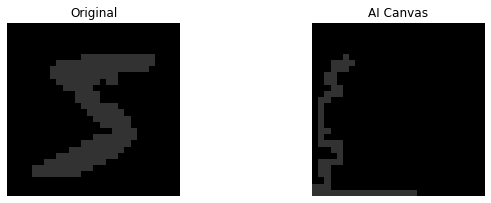

In [32]:
compute_avg_return(env,
                   random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                   env.action_spec()),
                   10)

## Replay Buffer

In [33]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=100000,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:150]  Initializing TFRecordCheckpointer in /tmp/tmporoeem6p.
[reverb/cc/platform/tfrecord_checkpointer.cc:386] Loading latest checkpoint from /tmp/tmporoeem6p
[reverb/cc/platform/default/server.cc:71] Started replay server on port 21140


### Testing the replay buffer

In [34]:
py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                        env.action_spec()),
        use_tf_function=True),
        [rb_observer],
        max_steps=100
    ).run(env_py.reset())

(TimeStep(
 {'discount': array(0.5, dtype=float32),
  'observation': array([ 0,  0,  0, ...,  0, 11, 27], dtype=int32),
  'reward': array(0., dtype=float32),
  'step_type': array(1, dtype=int32)}),
 ())

In [35]:
iter(replay_buffer.as_dataset()).next()

(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.18258245, 2.2373253 ])>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.5, 0.5], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 1570), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 5, 8],
        [0, 0, 0, ..., 0, 5, 9]], dtype=int32)>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-0.1, -0.1], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 SampleInfo(key=<tf.Tensor: shape=(2,), dtype=uint64, numpy=array([5268819462168331644, 5268819462168331644], dtype=uint64)>, probability=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.01030928, 0.01030928])>, table_size=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([97, 97])>, priority=<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])

In [36]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=2).prefetch(3)
iterator = iter(dataset)

[reverb/cc/platform/default/server.cc:84] Shutting down replay server


In [37]:
iterator = iter(dataset)
print(iterator)

In [38]:
next(iterator)

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (17498) so Table uniform_table is accessed directly without gRPC.


(Trajectory(
 {'action': <tf.Tensor: shape=(64, 2), dtype=float64, numpy=
 array([[1.965261  , 0.15414661],
        [0.36309406, 0.35516437],
        [1.23863906, 1.15499007],
        [0.93288685, 2.31067318],
        [2.66957274, 1.17546717],
        [2.2373253 , 1.8615808 ],
        [1.99902104, 0.41232564],
        [1.98257079, 0.23592932],
        [2.60517618, 2.59807351],
        [1.99902104, 0.41232564],
        [0.05159572, 2.57850054],
        [2.57850054, 1.84441445],
        [0.94655126, 0.00391525],
        [0.00634773, 1.78560981],
        [1.93235657, 0.58844613],
        [0.1594968 , 0.70676521],
        [0.05159572, 2.57850054],
        [0.00391525, 0.02578264],
        [2.56226146, 0.83508423],
        [1.33000647, 2.79545123],
        [1.90770566, 0.73361679],
        [1.58925753, 1.28751515],
        [0.41232564, 2.88777015],
        [0.64404493, 0.93288685],
        [2.33265944, 1.54661341],
        [2.79227767, 2.24530912],
        [0.10862437, 2.66957274],
        

## AI Training

In [39]:
agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=0>

In [40]:
time_step = env_py.reset()

In [41]:
# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env_py,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=1)

step = 100: loss = 0.958031177520752
step = 200: loss = 0.8176058530807495
step = 300: loss = 1.0132699012756348
step = 400: loss = 0.7003477811813354
step = 500: loss = 0.9448662400245667
step = 600: loss = 0.5744081735610962
step = 700: loss = 1.634141206741333
step = 800: loss = 0.45983877778053284
step = 900: loss = 1.0792008638381958
step = 1000: loss = 1.441831350326538
step = 1000: Average Return = 10.899998664855957
step = 1100: loss = 0.4503258466720581
step = 1200: loss = 0.7557124495506287
step = 1300: loss = 0.11256307363510132
step = 1400: loss = 2.391916036605835
step = 1500: loss = 0.05178048834204674
step = 1600: loss = 0.08325912803411484
step = 1700: loss = 0.2537404000759125
step = 1800: loss = 1.7922614812850952
step = 1900: loss = 0.1023540124297142
step = 2000: loss = 0.2429780662059784
step = 2000: Average Return = 10.899998664855957
step = 2100: loss = 0.716915488243103
step = 2200: loss = 0.2622659206390381
step = 2300: loss = 0.03794870153069496
step = 2400: l

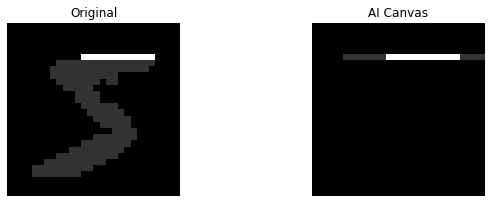

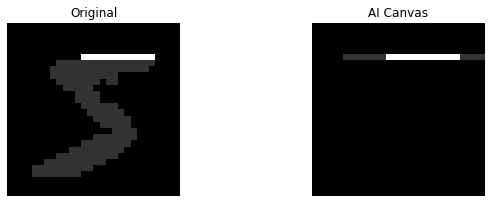

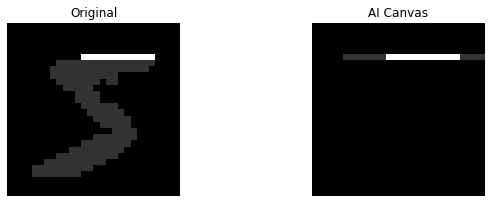

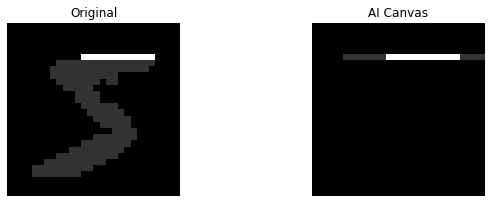

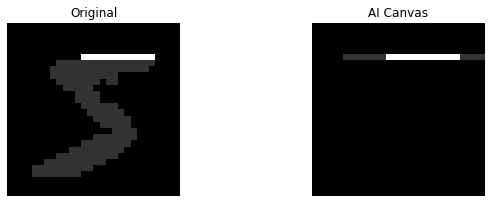

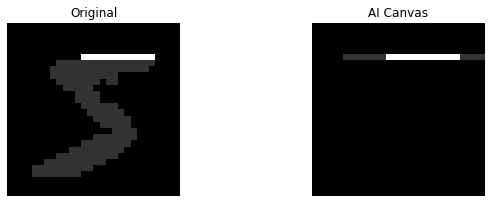

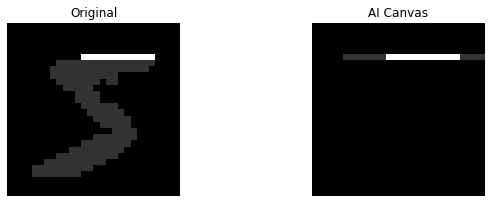

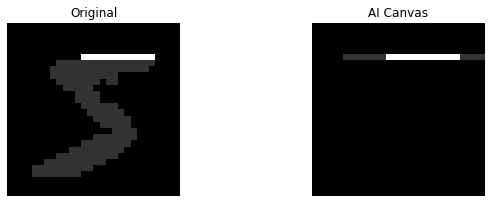

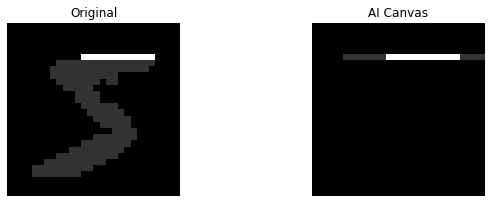

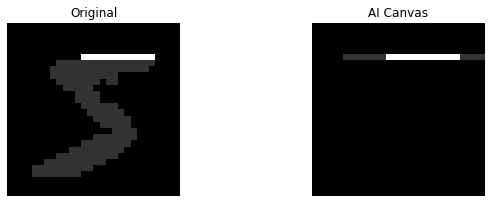

In [42]:
returns = []
for _ in range(1000):
    
  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % 100 == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % 500 == 0:
    avg_return = compute_avg_return(env, agent.policy, 1)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)